In [1]:
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt

from  invisible_cities.core .core_functions import in_range

to_df = pd.DataFrame.from_records

In [2]:
datadir  = "/Users/hernando/investigacion/NEXT/data/runV"
filename = "/7430/ntuple_combined_7430.h5"

In [3]:
f = tb.open_file(datadir + filename, 'r')
print(f)

/Users/hernando/investigacion/NEXT/data/runV/7430/ntuple_combined_7430.h5 (File) ''
Last modif.: 'Fri Sep  6 11:13:39 2019'
Object Tree: 
/ (RootGroup) ''
/PAOLINA (Group) ''
/PAOLINA/Summary (Table(602839,), shuffle, zlib(4)) 'Event summary information'



In [4]:
df = to_df(f.root.PAOLINA.Summary.read())

In [5]:
labels = list(df.columns)
print(labels)

['event', 'time', 'S1e', 'S1t', 'nS2', 'ntrks', 'nhits', 'S2e0', 'S2ec', 'S2q0', 'S2qc', 'x_avg', 'y_avg', 'z_avg', 'r_avg', 'x_min', 'y_min', 'z_min', 'r_min', 'x_max', 'y_max', 'z_max', 'r_max']


In [6]:
def select_in_range(vals, range = None):
    if (range is None): range = (np.min(vals), np.max(vals) + 0.1)
    sel = (vals >= range[0]) & (vals < range[1]) 
    return sel

def stats(vals, range = None):
    sel = select_in_range(vals, range)
    vv = vals[sel]
    mean, std, evts, oevts = np.mean(vv), np.std(vv), len(vv), len(vals) - len(vv)
    return evts, mean, std, oevts

def sstats(vals, range = None, formate = '6.2f'):
    evts, mean, std, ovts = stats(vals, range)
    s  = 'events '+str(evts)+'\n'
    s += (('mean {0:'+formate+'}').format(mean))+'\n'
    s += (('std  {0:'+formate+'}').format(std))
    return s


In [7]:
def hist(vv, range = None, fig = None, title = ''):
    s = sstats(vv, range = range)
    if (fig is None): fig = plt.figure()
    pt = plt.hist(vv, bins= 100, range = range, histtype='step', label = s);
    plt.title(title)
    plt.legend();
    return fig, pt
    

### quick look at the variables

/Users/hernando/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/hernando/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/hernando/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


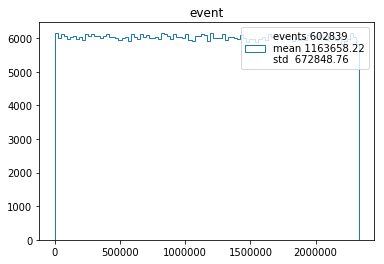

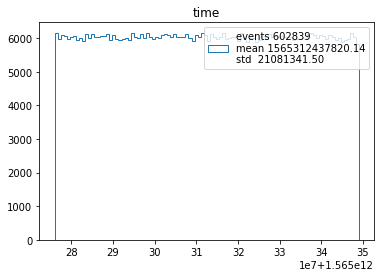

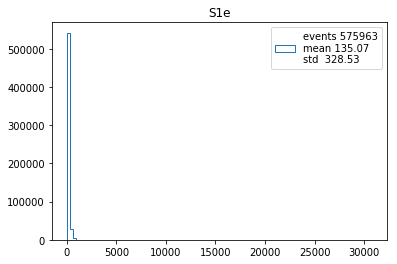

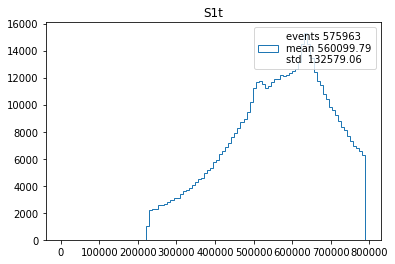

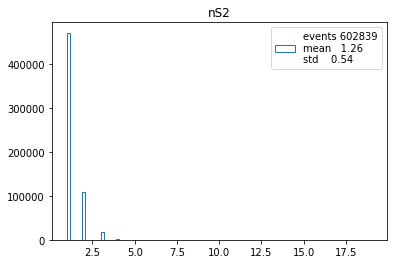

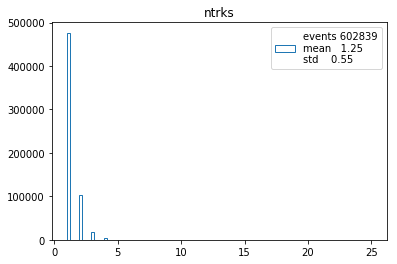

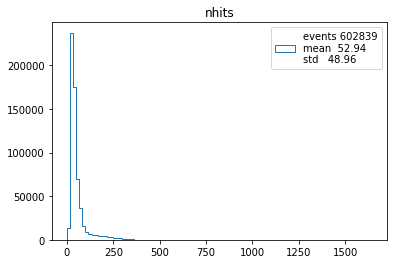

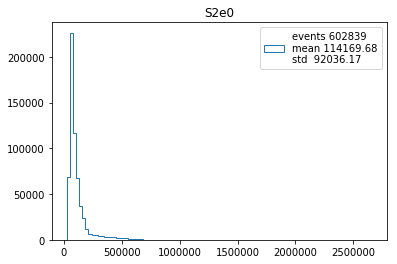

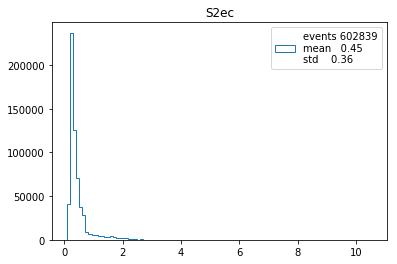

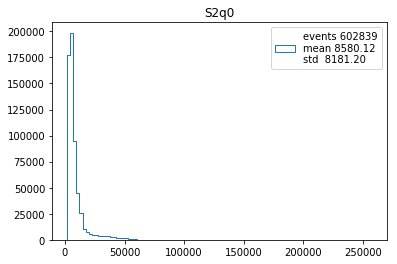

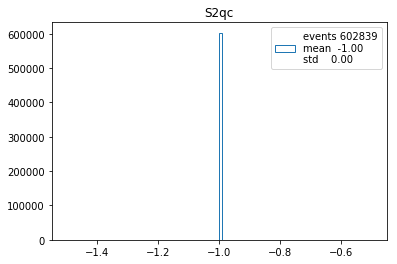

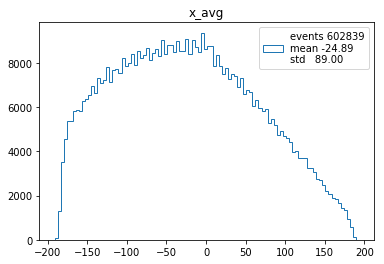

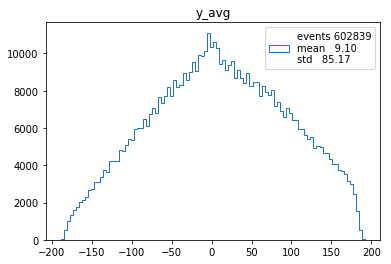

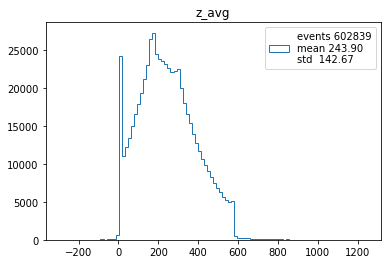

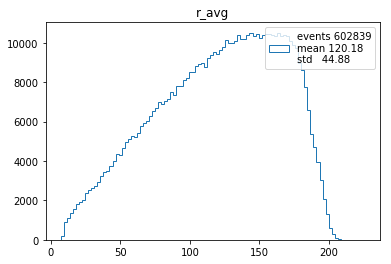

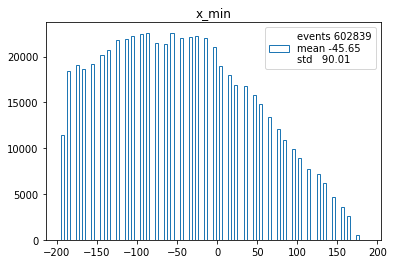

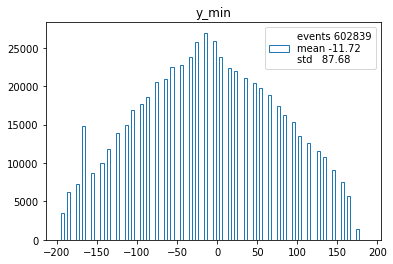

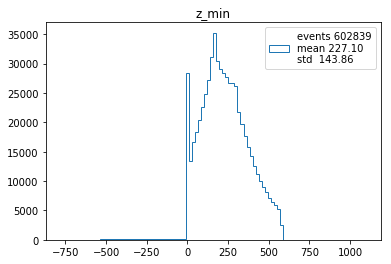

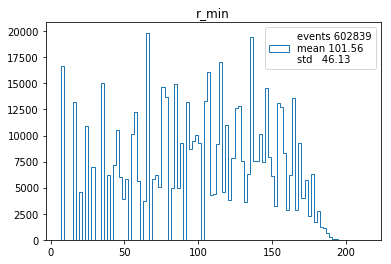

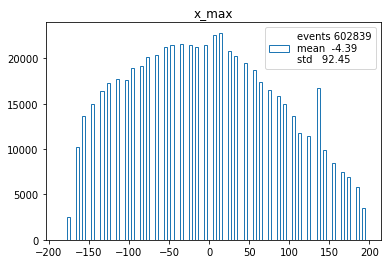

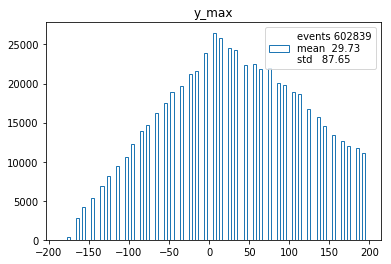

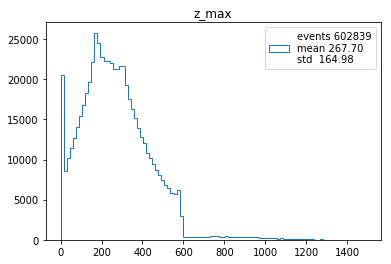

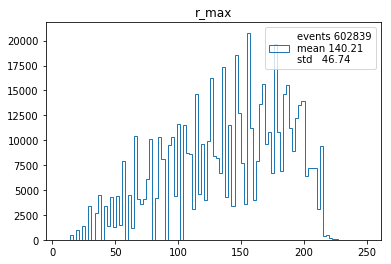

In [8]:
for label in labels:
    hist(df[label], title = label)

### Energy distribution

In [9]:
import csth.utils.fits as efit

def plot_extll_fit(es, e0, e1, mushat, nbins = 100, alpha = 0.5, tag = ''):
    pg = efit.Pol1DGaus(a = e0, b = e1, shapes = 'mu, sigma, mslope, f')
    mu, sigma, mslope, nug, nup = mushat[0], mushat[1], mushat[2], mushat[3], mushat[4]
    ntot = nug + nup
    f = float(nug)/float(nug+nup)
    pf = efit.Pol1DGaus(a = e0, b = e1, shapes = 'mu, sigma, mslope, f')
    xs = np.linspace(e0, e1, nbins)
    dx = xs[1]-xs[0]
    ys = ntot * dx * pg.pdf(xs, mu = mu, sigma = sigma, mslope = mslope, f = f)
    plt.hist(es, nbins, range = (e0, e1), alpha = alpha)
    fwhm = 235.* sigma/mu
    label = tag + ' n = ' + str(int(nug)) + '\n $\mu$ = ' + "{0:.3f}".format(mu) + '\n FWHM (%) = ' + "{0:.3f}".format(fwhm)
    plt.plot(xs, ys, ls= '-', lw = 2, label = label, alpha = alpha)
    plt.xlim(e0, e1)
    plt.legend()
    return (xs, ys)

In [10]:
def canvas_esigma(ec, erange, nbins= 100, tag='', alpha = 0.5):
    e0, e1 = erange
    dssel = in_range(ec, e0, e1)
    es = ec[dssel]
    mushat = efit.extll_fit_pol1dgaus(es, e0, e1)
    print(es.min(), es.max())
    #plt.hist(es, nbins, range = (360e3, 440e3))
    #plt.xlim(e0, e1)
    dat = plot_extll_fit(es, e0, e1, mushat, tag = tag, alpha = alpha)
    return mushat, dat

1.500035180655385 1.7999461568501962


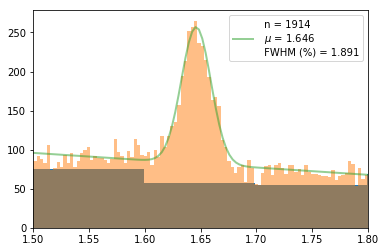

In [11]:
 canvas_esigma(df['S2ec'], (1.5, 1.8), alpha = 0.5);

In [12]:
S2ec = df['S2ec'].values
S2dz = df['z_max'].values - df['z_min'].values
sel_dsp = in_range(S2ec, 1.55, 1.72) & in_range(S2dz, 0., 150.)

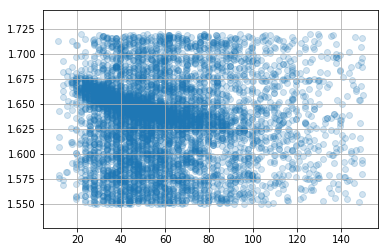

In [13]:
plt.scatter(S2dz[sel_dsp], S2ec[sel_dsp], alpha = 0.2);
plt.grid()

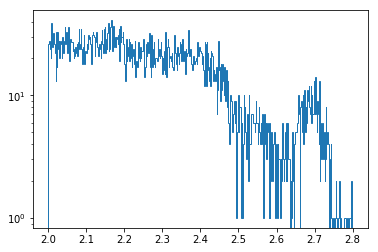

In [14]:
plt.hist(df['S2ec'], 500, range = (2.0, 2.8), histtype = 'step');
plt.yscale('log')

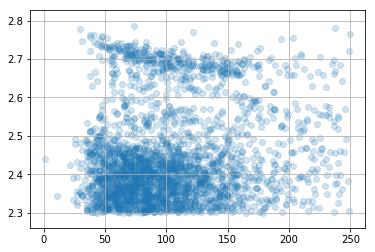

In [15]:
sel_tlph = in_range(S2ec, 2.3, 2.8) & in_range(S2dz, 0., 250.)
plt.scatter(S2dz[sel_tlph], S2ec[sel_tlph], alpha = 0.2);
plt.grid()

In [16]:
#CAL_a = -0.006680368665624783
#CAL_b = 0.9571139335090242
#CAL_c = 0.010639589186562352
# Calibrate the energy.
#Ec = CAL_a * (S2ec*S2ec) + CAL_b * S2ec + CAL_c

In [17]:
zwidth = df['z_max'] - df['z_min']
S2eczc = S2ec/(1 - 2.76e-4*zwidth)

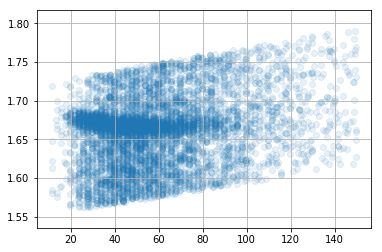

In [18]:
plt.scatter(S2dz[sel_dsp], S2eczc[sel_dsp], alpha = 0.1);
plt.grid()

1.5000446431509478 1.7999699380766156


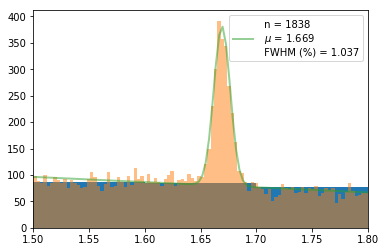

In [19]:
canvas_esigma(S2eczc, (1.5, 1.8), alpha = 0.5);

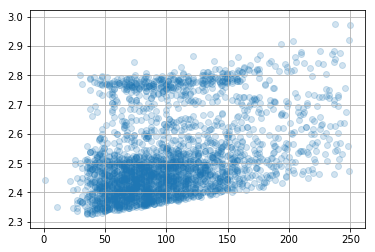

In [20]:
plt.scatter(S2dz[sel_tlph], S2eczc[sel_tlph], alpha = 0.2);
plt.grid()

2.7006302395110597 2.89901477729036


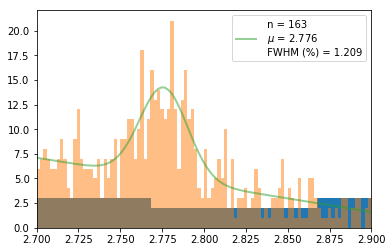

In [21]:
canvas_esigma(S2eczc, (2.7, 2.9), alpha = 0.5);

In [22]:
ntrks = df['ntrks']
sel_dsp = in_range(S2eczc, 1.640, 1.700) & in_range(S2dz, 0., 150.) & in_range(ntrks, 0.5, 1.5)
sel_php = in_range(S2eczc, 2.735, 2.810) & in_range(S2dz, 0., 250.) & in_range(ntrks, 0.5, 1.5)

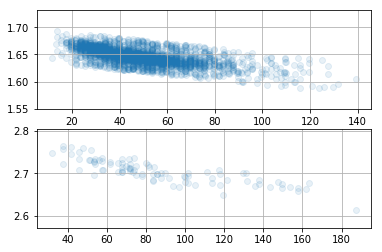

In [23]:
plt.subplot(2, 1, 1)
plt.scatter(S2dz[sel_dsp], S2ec[sel_dsp], alpha = 0.1);
plt.grid()
plt.subplot(2, 1, 2)
plt.scatter(S2dz[sel_php], S2ec[sel_php], alpha = 0.1);
plt.grid()

## correlations

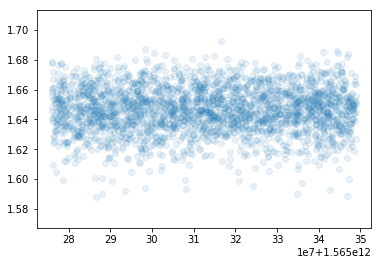

In [24]:
etime = df['time']
plt.scatter(etime[sel_dsp], S2ec[sel_dsp], alpha = 0.1);

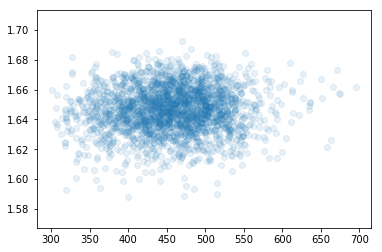

In [25]:
S1e = df['S1e']
_sel = sel_dsp & in_range(S1e, 200., 700.)
plt.scatter(S1e[_sel], S2ec[_sel], alpha = 0.1);

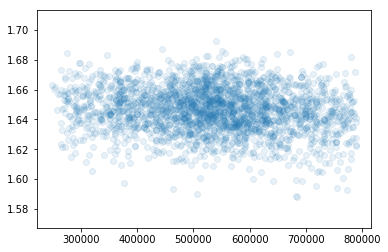

In [26]:
S1t = df['S1t']
#_sel = sel_dsp & in_range(S1t, 200., 700.)
plt.scatter(S1t[_sel], S2ec[_sel], alpha = 0.1);

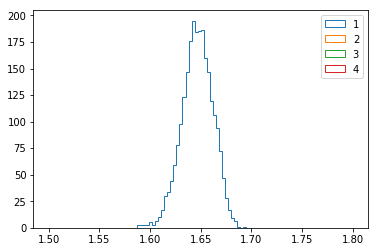

In [27]:
ntrks = df['ntrks']
for i in range(1, 5):
    _sel = sel_dsp & in_range(ntrks, i-0.5, i+0.5)
    plt.hist(S2ec[_sel], range = (1.5, 1.8), bins = 100, alpha = 1., histtype = 'step', label = str(i));
plt.legend();

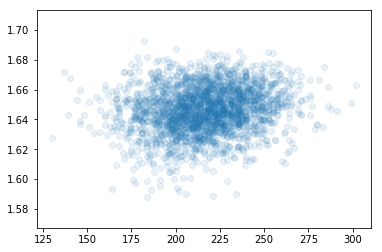

In [28]:
nhits = df['nhits']
#_sel = sel_dsp & in_range(S1t, 200., 700.)
plt.scatter(nhits[sel_dsp], S2ec[sel_dsp], alpha = 0.1);

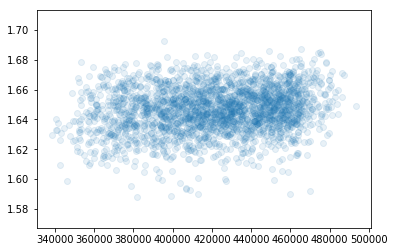

In [29]:
S2e0 = df['S2e0']
#_sel = sel_dsp & in_range(S1t, 200., 700.)
plt.scatter(S2e0[sel_dsp], S2ec[sel_dsp], alpha = 0.1);

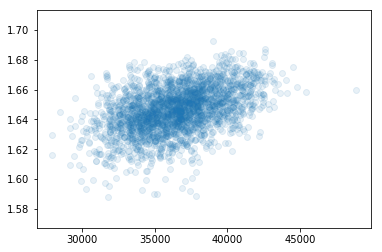

In [30]:
S2q0 = df['S2q0']
#_sel = sel_dsp & in_range(S1t, 200., 700.)
plt.scatter(S2q0[sel_dsp], S2ec[sel_dsp], alpha = 0.1);

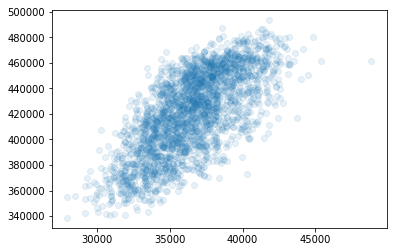

In [31]:
plt.scatter(S2q0[sel_dsp], S2e0[sel_dsp], alpha = 0.1);

In [32]:
fc = S2ec/S2e0

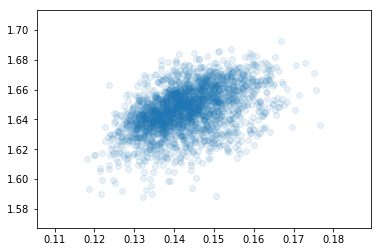

In [33]:
plt.scatter(fc[sel_dsp] * S2q0[sel_dsp], S2ec[sel_dsp], alpha = 0.1);

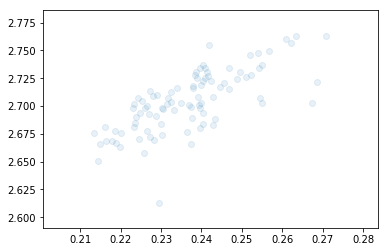

In [34]:
plt.scatter(fc[sel_php] * S2q0[sel_php], S2ec[sel_php], alpha = 0.1);

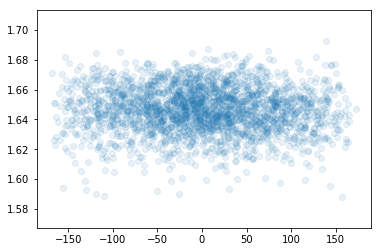

In [37]:
x_avg = df['x_avg']
plt.scatter(x_avg[sel_dsp], S2ec[sel_dsp], alpha = 0.1);

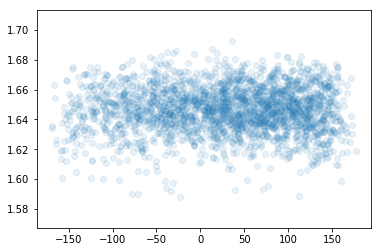

In [38]:
y_avg = df['y_avg']
plt.scatter(y_avg[sel_dsp], S2ec[sel_dsp], alpha = 0.1);

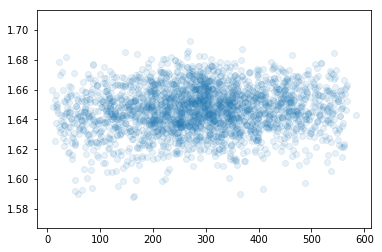

In [39]:
z_avg = df['z_avg']
plt.scatter(z_avg[sel_dsp], S2ec[sel_dsp], alpha = 0.1);

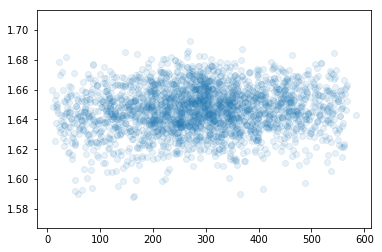

In [40]:
z_min = df['z_min']
plt.scatter(z_avg[sel_dsp], S2ec[sel_dsp], alpha = 0.1);

In [ ]:
df.hist('nhits', bins= 100, range = (0., 500), histtype='step');

## Filters

In [4]:
print(f.root.Filters._v_children)

{'NN_select': /Filters/NN_select (Table(57,), shuffle, zlib(4)) 'Event has passed filter flag'
  description := {
  "event": Int32Col(shape=(), dflt=0, pos=0),
  "passed": BoolCol(shape=(), dflt=False, pos=1)}
  byteorder := 'little'
  chunkshape := (13107,), 'paolina_select': /Filters/paolina_select (Table(57,), shuffle, zlib(4)) 'Event has passed filter flag'
  description := {
  "event": Int32Col(shape=(), dflt=0, pos=0),
  "passed": BoolCol(shape=(), dflt=False, pos=1)}
  byteorder := 'little'
  chunkshape := (13107,)}


In [5]:
to_df(f.root.Filters.NN_select.read())

,event,passed
0,1,True
1,6,True
2,7,True
3,13,True
4,14,True
5,19,True
6,24,True
7,49,True
8,56,True
9,62,True


In [6]:
to_df(f.root.Filters.paolina_select.read())

,event,passed
0,1,True
1,6,True
2,7,True
3,13,True
4,14,True
5,19,True
6,24,True
7,49,True
8,56,False
9,62,True


## Run

In [7]:
print(f.root.Run._v_children)

{'events': /Run/events (Table(53,), shuffle, zlib(4)) 'event info table'
  description := {
  "evt_number": Int32Col(shape=(), dflt=0, pos=0),
  "timestamp": UInt64Col(shape=(), dflt=0, pos=1)}
  byteorder := 'little'
  chunkshape := (5461,), 'runInfo': /Run/runInfo (Table(53,), shuffle, zlib(4)) 'run info table'
  description := {
  "run_number": Int32Col(shape=(), dflt=0, pos=0)}
  byteorder := 'little'
  chunkshape := (16384,)}


In [8]:
to_df(f.root.Run.events.read())

,evt_number,timestamp
0,1,1548430251524
1,6,1548430251677
2,7,1548430251725
3,13,1548430251898
4,14,1548430251928
5,19,1548430252151
6,24,1548430252308
7,49,1548430253244
8,62,1548430253972
9,64,1548430254012


In [9]:
to_df(f.root.Run.runInfo.read())

,run_number
0,6822
1,6822
2,6822
3,6822
4,6822
5,6822
6,6822
7,6822
8,6822
9,6822


## PAOLINA

In [10]:
print(f.root.PAOLINA._v_children)

{'Events': /PAOLINA/Events (Table(2941,), shuffle, zlib(4)) 'Hits'
  description := {
  "event": Int32Col(shape=(), dflt=0, pos=0),
  "time": Float64Col(shape=(), dflt=0.0, pos=1),
  "npeak": UInt16Col(shape=(), dflt=0, pos=2),
  "Xpeak": Float64Col(shape=(), dflt=0.0, pos=3),
  "Ypeak": Float64Col(shape=(), dflt=0.0, pos=4),
  "nsipm": UInt16Col(shape=(), dflt=0, pos=5),
  "X": Float64Col(shape=(), dflt=0.0, pos=6),
  "Y": Float64Col(shape=(), dflt=0.0, pos=7),
  "Xrms": Float64Col(shape=(), dflt=0.0, pos=8),
  "Yrms": Float64Col(shape=(), dflt=0.0, pos=9),
  "Z": Float64Col(shape=(), dflt=0.0, pos=10),
  "Q": Float64Col(shape=(), dflt=0.0, pos=11),
  "E": Float64Col(shape=(), dflt=0.0, pos=12),
  "Qc": Float64Col(shape=(), dflt=0.0, pos=13),
  "Ec": Float64Col(shape=(), dflt=0.0, pos=14),
  "track_id": Int32Col(shape=(), dflt=0, pos=15)}
  byteorder := 'little'
  chunkshape := (606,)
  autoindex := True
  colindexes := {
    "event": Index(6, medium, shuffle, zlib(1)).is_csi=False}, 

In [11]:
to_df(f.root.PAOLINA.Events.read())

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id
0,1,1.548430e+09,0,71.827047,-166.350778,1,65.0,-175.0,0.0,0.0,431.374375,81.982887,1578.286378,-1.0,0.008392,0
1,1,1.548430e+09,0,71.827047,-166.350778,1,65.0,-185.0,0.0,0.0,431.374375,39.967648,769.433668,-1.0,0.003496,0
2,1,1.548430e+09,0,71.827047,-166.350778,1,55.0,-175.0,0.0,0.0,431.374375,35.895306,691.035334,-1.0,0.003523,0
3,1,1.548430e+09,0,71.827047,-166.350778,1,65.0,-175.0,0.0,0.0,433.252750,132.968704,2095.996652,-1.0,0.011150,0
4,1,1.548430e+09,0,71.827047,-166.350778,1,65.0,-185.0,0.0,0.0,433.252750,62.991848,992.945696,-1.0,0.004514,0
5,1,1.548430e+09,0,71.827047,-166.350778,1,55.0,-175.0,0.0,0.0,433.252750,51.848774,817.296501,-1.0,0.004169,0
6,1,1.548430e+09,0,71.827047,-166.350778,1,65.0,-175.0,0.0,0.0,435.144500,148.090637,2721.646029,-1.0,0.014485,0
7,1,1.548430e+09,0,71.827047,-166.350778,1,65.0,-185.0,0.0,0.0,435.144500,50.712273,932.002577,-1.0,0.004238,0
8,1,1.548430e+09,0,71.827047,-166.350778,1,55.0,-175.0,0.0,0.0,435.144500,47.029495,864.319591,-1.0,0.004411,0
9,1,1.548430e+09,0,71.827047,-166.350778,1,65.0,-175.0,0.0,0.0,437.063250,74.161194,1837.272982,-1.0,0.009784,0


In [12]:
to_df(f.root.PAOLINA.Summary.read())

,event,time,S1e,S1t,nS2,ntrks,nhits,S2e0,S2ec,S2q0,...,z_avg,r_avg,x_min,y_min,z_min,r_min,x_max,y_max,z_max,r_max
0,1,1548430251524,155.554077,371825.0,1,1,59,81806.687500,0.424353,7074.975586,...,8.399803e+07,3.621017e+07,55.0,-185.0,431.374375,168.077363,95.0,-155.0,441.067688,203.592731
1,6,1548430251677,66.309341,712350.0,1,1,31,77315.859375,0.305464,5655.356934,...,2.235466e+07,3.788874e+07,-115.0,-135.0,89.904688,143.003496,-85.0,-115.0,99.249188,169.852878
2,7,1548430251725,67.318184,472500.0,1,1,45,71732.382812,0.281578,5327.535156,...,8.508802e+07,3.531948e+07,-115.0,-115.0,330.655625,120.208153,-85.0,-85.0,338.203312,155.724115
3,13,1548430251898,88.651703,445225.0,1,1,39,56673.597656,0.304134,4692.257812,...,6.724863e+07,3.349080e+07,-115.0,135.0,357.932375,159.530561,-85.0,165.0,363.579313,195.576072
4,14,1548430251928,43.944778,649675.0,1,1,22,55666.972656,0.213393,3686.593750,...,3.821952e+07,3.156439e+07,-135.0,-25.0,152.504000,115.974135,-115.0,-15.0,159.942375,137.295302
5,19,1548430252151,91.946854,539625.0,1,1,41,85341.453125,0.340980,6393.396484,...,6.669122e+07,3.643944e+07,-75.0,-145.0,263.555875,127.475488,-45.0,-115.0,271.083438,163.248277
6,24,1548430252308,216.049179,777775.0,4,3,86,233723.876953,0.988531,17330.315979,...,1.172203e+07,3.086131e+07,-155.0,95.0,24.514688,114.236597,65.0,135.0,159.099000,181.796590
7,49,1548430253244,245.103836,257100.0,2,1,69,133012.674683,0.581664,9050.216507,...,1.266926e+08,2.200604e+07,55.0,45.0,544.183562,77.781746,95.0,75.0,569.787000,109.772492
8,62,1548430253972,57.820671,648325.0,2,1,22,61258.748047,0.232195,4693.382172,...,3.010342e+07,3.441426e+07,-195.0,-15.0,152.964500,165.075740,-165.0,-5.0,158.379188,195.576072
9,64,1548430254012,42.116154,573525.0,1,1,23,49979.160156,0.181953,2842.849609,...,5.898866e+07,1.903762e+07,-55.0,-75.0,229.498188,65.192024,-25.0,-55.0,237.224000,85.146932


In [13]:
to_df(f.root.PAOLINA.Tracks.read())

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,blob_overlap,vox_size_x,vox_size_y,vox_size_z
0,1,0,0.424353,36.213203,6,59,1,55.0,-185.0,431.374375,...,435.510828,63.402359,-177.084122,434.430238,0.290505,0.263830,True,15.0,15.0,15.0
1,6,0,0.305464,21.213203,3,31,1,-115.0,-135.0,89.904688,...,92.430014,-92.833759,-135.000000,92.013198,0.284805,0.278185,True,15.0,15.0,15.0
2,7,0,0.281578,21.213203,4,45,1,-115.0,-115.0,330.655625,...,334.185126,-105.620187,-107.194146,333.492166,0.245365,0.216286,True,15.0,15.0,15.0
3,13,0,0.304134,21.213203,4,39,1,-115.0,135.0,357.932375,...,360.918241,-93.742645,156.791933,360.682184,0.258370,0.228251,True,15.0,15.0,15.0
4,14,0,0.213393,15.000000,2,22,1,-135.0,-25.0,152.504000,...,156.773076,-135.000000,-21.954508,155.957157,0.213393,0.205697,True,15.0,15.0,15.0
5,19,0,0.340980,21.213203,4,41,1,-75.0,-145.0,263.555875,...,266.892608,-53.847225,-123.682090,266.213557,0.310530,0.248755,True,15.0,15.0,15.0
6,24,0,0.031920,0.000000,1,2,3,-155.0,95.0,134.296562,...,134.893183,-155.000000,95.000000,134.893183,0.031920,0.031920,True,15.0,15.0,15.0
7,24,1,0.130861,21.213203,4,14,3,-125.0,95.0,143.482687,...,143.482687,-115.000000,115.000000,158.421523,0.106382,0.085593,True,15.0,15.0,15.0
8,24,2,0.825750,47.193966,12,70,3,25.0,105.0,24.514688,...,25.455021,32.952975,135.000000,53.036067,0.421210,0.266700,False,15.0,15.0,15.0
9,49,0,0.581664,40.980762,12,69,1,55.0,45.0,544.183562,...,566.697263,63.915460,52.545540,549.736688,0.361918,0.301712,True,15.0,15.0,15.0


## RECO

In [14]:
print(f.root.RECO._v_children)

{'Events': /RECO/Events (Table(13076,), shuffle, zlib(4)) 'Hits'
  description := {
  "event": Int32Col(shape=(), dflt=0, pos=0),
  "time": Float64Col(shape=(), dflt=0.0, pos=1),
  "npeak": UInt16Col(shape=(), dflt=0, pos=2),
  "Xpeak": Float64Col(shape=(), dflt=0.0, pos=3),
  "Ypeak": Float64Col(shape=(), dflt=0.0, pos=4),
  "nsipm": UInt16Col(shape=(), dflt=0, pos=5),
  "X": Float64Col(shape=(), dflt=0.0, pos=6),
  "Y": Float64Col(shape=(), dflt=0.0, pos=7),
  "Xrms": Float64Col(shape=(), dflt=0.0, pos=8),
  "Yrms": Float64Col(shape=(), dflt=0.0, pos=9),
  "Z": Float64Col(shape=(), dflt=0.0, pos=10),
  "Q": Float64Col(shape=(), dflt=0.0, pos=11),
  "E": Float64Col(shape=(), dflt=0.0, pos=12),
  "Qc": Float64Col(shape=(), dflt=0.0, pos=13),
  "Ec": Float64Col(shape=(), dflt=0.0, pos=14),
  "track_id": Int32Col(shape=(), dflt=0, pos=15)}
  byteorder := 'little'
  chunkshape := (606,)
  autoindex := True
  colindexes := {
    "event": Index(6, medium, shuffle, zlib(1)).is_csi=False}}


In [14]:
to_df(f.root.RECO.Events.read())

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id
0,1,1.548430e+09,0,71.827047,-166.350778,1,75.0,-175.0,0.0,0.0,427.712125,6.406268,120.680970,-1.0,0.000660,-1
1,1,1.548430e+09,0,71.827047,-166.350778,1,65.0,-165.0,0.0,0.0,429.474812,21.964869,260.173694,-1.0,0.001302,-1
2,1,1.548430e+09,0,71.827047,-166.350778,1,75.0,-175.0,0.0,0.0,429.474812,17.740437,210.135331,-1.0,0.001150,-1
3,1,1.548430e+09,0,71.827047,-166.350778,1,75.0,-165.0,0.0,0.0,429.474812,16.853176,199.625738,-1.0,0.001018,-1
4,1,1.548430e+09,0,71.827047,-166.350778,1,75.0,-185.0,0.0,0.0,429.474812,12.907502,152.889261,-1.0,0.000694,-1
5,1,1.548430e+09,0,71.827047,-166.350778,1,65.0,-175.0,0.0,0.0,429.474812,10.834487,128.334412,-1.0,0.000682,-1
6,1,1.548430e+09,0,71.827047,-166.350778,1,75.0,-155.0,0.0,0.0,429.474812,9.993187,118.369220,-1.0,0.000568,-1
7,1,1.548430e+09,0,71.827047,-166.350778,1,85.0,-175.0,0.0,0.0,429.474812,9.830750,116.445150,-1.0,0.000689,-1
8,1,1.548430e+09,0,71.827047,-166.350778,1,55.0,-175.0,0.0,0.0,429.474812,8.973826,106.294903,-1.0,0.000542,-1
9,1,1.548430e+09,0,71.827047,-166.350778,1,85.0,-155.0,0.0,0.0,429.474812,8.720091,103.289407,-1.0,0.000510,-1


In [16]:
f.close()